<br>

# EDA Linear Array

<br>

## environmental

<br>

In [1]:
#load methods
from scipy.io import loadmat
#import pyspike as spk
#from quantities import ms, s, Hz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import math

In [ ]:
#load .mat into python environment @ old machine
#linArrayPath = "/home/bonzilla/Desktop/scienceLife/linArray/linArray/T35_083018_t2_spikingDAT.mat"
#linArrayMat = loadmat( linArrayPath )

In [22]:
#load .mat into python environment @ new machine
linArrayPath = "/home/bonzilla/Documents/ScienceLife/linArray/linArray_data/T35_083018_t2_spikingDAT.mat"
#linArrayPath = "/home/bonzilla/Documents/ScienceLife/linArray/linArray_data/T35_083018_t3_spikingDAT.mat"
#linArrayPath = "/home/bonzilla/Documents/ScienceLife/linArray/linArray_data/T35_083018_t1_spikingDAT.mat"
linArrayMat = loadmat( linArrayPath )

In [23]:
print( type( linArrayMat ) )
linArrayMat.keys()

<class 'dict'>


dict_keys(['__header__', '__version__', '__globals__', 'SPK09i', 'SPK10i', 'SPK11i', 'SPK12i', 'SPK13a', 'SPK13i', 'SPK14i', 'SPK15a', 'SPK15i', 'SPK16a', 'SPK16i', 'Start', 'Stop', 'Strobed00001', 'Strobed00003', 'Strobed00005', 'Strobed00006', 'Strobed00007', 'Strobed00009', 'Strobed00010', 'Strobed00013', 'Strobed00014', 'Strobed00016', 'Strobed00017', 'Strobed00018', 'Strobed00030', 'Strobed00040', 'Strobed00041', 'Strobed00043', 'Strobed00046', 'Strobed00050', 'Strobed00100', 'Strobed00102', 'Strobed00131', 'Strobed00161', 'Strobed00235', 'Strobed00360', 'Strobed00400', 'Strobed00555', 'Strobed00666', 'Strobed00830', 'Strobed01000', 'Strobed01618', 'Strobed01808', 'Strobed02000', 'Strobed02018', 'Strobed05555', 'catSearchPHYSIOLIntervals', 'delayedSacc180RFInt', 'delayedSaccIntervals', 'plxDataIntervals'])

<br>

## reshape mat struct

reshape the imported matlab structure tosomethng more pythonic  
the matlab struct for the linear array is imported by `loadmat()` as a python dictionary. to facilitate further analysis, we will massage the data into a more workable form as a pandas dataframe...

<br>

### understanding the dictionary fields

The linear array data holds a matlab structure for a saved workspace after imporing the neural data + strobed eventmarkers + trial intervals from NeuralExplorer. The field `plxDataIntervals` has interval information for all trials whereas `delayedSaccIntervals` and other task specific fields hold filtered trial intervals. For example, `delayedSaccIntervals` holds only correct trials for the delayed saccade task.  

The following code shows how to access these intervals as pandas dataframes:

<br>

In [24]:
# the delayedSaccIntervals field
delayedSaccade_dat = linArrayMat[ 'delayedSaccIntervals' ]
delayedSaccade_DF = pd.DataFrame( data = delayedSaccade_dat, columns = [ 'start','end' ] )
print( delayedSaccade_DF.shape )
delayedSaccade_DF

(31, 2)


,start,end
0,0.0000,21.2835
1,21.8320,24.9940
2,25.4360,28.7080
3,29.2500,32.3125
4,32.8540,36.1360
5,36.6780,39.7405
6,40.2820,43.4540
7,43.8860,47.0590
8,49.6730,53.2755
9,55.7915,58.7440


In [ ]:
# the delayedSaccIntervals 180 field
#delayedSaccade_dat = linArrayMat[ 'delayedSacc180RFInt' ]
#delayedSaccade_DF = pd.DataFrame( data = delayedSaccade_dat, columns = [ 'start','end' ] )
#print( delayedSaccade_DF.shape )
#delayedSaccade_DF

In [26]:
#the catSearchPHYSIOLIntervals feld
catSearchPHYSIOL_dat = linArrayMat[ 'catSearchPHYSIOLIntervals' ]
catSearchPHYSIOL_DF = pd.DataFrame( data = catSearchPHYSIOL_dat, columns = [ 'start','end' ] )
print( catSearchPHYSIOL_DF.shape )
catSearchPHYSIOL_DF.head()

(150, 2)


,start,end
0,362.9720,366.9035
1,367.4555,370.5080
2,371.0595,374.5520
3,375.0975,378.5905
4,379.1320,383.3935


In [27]:
# total trials
plxDataIntervals_dat = linArrayMat[ 'plxDataIntervals' ]
plxDataIntervals_DF = pd.DataFrame( data = plxDataIntervals_dat, columns = [ 'start','end' ] )
print( plxDataIntervals_DF.shape )
plxDataIntervals_DF.head()

(423, 2)


,start,end
0,0.000,21.2835
1,21.832,24.9940
2,25.436,28.7080
3,29.250,32.3125
4,32.854,36.1360


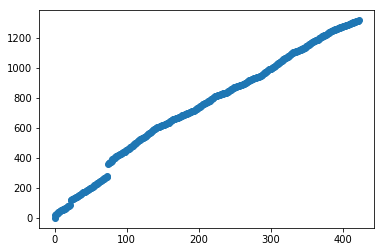

In [28]:
# plot
plt.plot( 'start', data=plxDataIntervals_DF, linestyle='none', marker='o')
plt.show()

In [29]:
plxDataIntervals_DF.iloc[0:30,:]

,start,end
0,0.0000,21.2835
1,21.8320,24.9940
2,25.4360,28.7080
3,29.2500,32.3125
4,32.8540,36.1360
5,36.6780,39.7405
6,40.2820,43.4540
7,43.8860,47.0590
8,47.5990,49.1315
9,49.6730,53.2755


In [30]:
# spiking data for a channel 
spike_dat = linArrayMat[ 'SPK14i' ]
print( spike_dat.shape )
print( spike_dat[0:10], )

(51119, 1)
[[0.0025]
 [0.003 ]
 [0.0055]
 [0.0075]
 [0.0105]
 [0.019 ]
 [0.0265]
 [0.0325]
 [0.0365]
 [0.0435]]


In [ ]:
# field potnetial data for channel 9
#FP09_dat = linArrayMat[ 'FP09' ]
#print( len( FP09_dat ) )
#print( FP09_dat[0:10] )

In [31]:
# a dataframe that holds columns names for all channels with spike data    
allKeys = pd.DataFrame( linArrayMat.keys(), columns = [ 'channels' ] )
spikeKeys_IDX = allKeys['channels'].str.startswith( 'SPK' )
spikeKeys = allKeys[ spikeKeys_IDX ]
print( len( spikeKeys ) )
spikeKeys.head()

11


,channels
3,SPK09i
4,SPK10i
5,SPK11i
6,SPK12i
7,SPK13a


<br>

Great. So we can access fields from that .mat struct as pandas objects and learn more about their contents.  
Next, we define some helper functions to format the data into organized dataframes that will better facilitate downstream analysis.  

We would like to be able to pull out certain types of data (e.g. spike, or field potentil data) for a specific type of trial interval and also organize timestamp information for eventmarkers of interest

<br>

In [32]:
# some helper functions to help format the linear array dictionary
def getStartEndTimestamps( array_DF, task, **kwargs ):
    """
    return the trial start and end timestamps for a task
    can work with taskname (string) 
    or combo taskname and timeint (list, len=2)
    """
    timeint = kwargs.get( 'timeint', None )
    if timeint:
        task_dat = array_DF[ task ]
        task_DF = pd.DataFrame( data = task_dat, 
                           columns = [ 'start','end' ] )
        task_DF = task_DF[ task_DF['start'].ge(timeint[0]) & task_DF['start'].lt(timeint[1]) ]
    else:
        task_dat = array_DF[ task ]
        task_DF = pd.DataFrame( data = task_dat, 
                           columns = [ 'start','end' ] )
    return task_DF

def formatStrobedEventSTR( eventmarker_int ):
    #make a string for the strobed event column label
    numZeros = 12 - 7 - len( str( eventmarker_int ) )
    strobedLabel = 'Strobed' + '0'*numZeros + str( eventmarker_int )
    return strobedLabel

def getChannelTrialData( array_DF, task, channel, **kwargs ):
    """
    generates a list for each trial within a pandas series for a specific task.
    array_DF: pandas dataframe with array data
    task: string for task batched data intervals
    channel: string for a plexon channel (e.g. SPK or FP)
    returns a pandas series of lists for trial data of a given channel
    """
    timeint = kwargs.get( 'timeint', None )
    # a DF of all the spike timestamps for `channel`
    channelDat = array_DF[ channel ]
    channelDat_DF = pd.DataFrame( data = channelDat, 
                                 columns = [ 'timestamps' ] )
    # a DF for all the start/stop timestamps for each trial for `task`
    task_DF = getStartEndTimestamps( array_DF, task, **kwargs )
    numTrials = len( task_DF[ 'start' ] )
    timeStampLists = pd.Series([], dtype= 'float64')
    
    #for each trial, get the spike timestamps inbetween the trial
    #start/end and format as a list
    for aTrial in range( numTrials ):
        startTime = task_DF[ 'start' ][ aTrial ]
        endTime = task_DF[ 'end' ][ aTrial ]
        trialTimeStamps_IDX = channelDat_DF[ 'timestamps' ].between( startTime, endTime )
        trialTimeStamps = channelDat_DF[ trialTimeStamps_IDX ]
        listoflists_TS = trialTimeStamps.values.tolist()  
        timeStampLists[ aTrial ] = [item for sublist in listoflists_TS for item in sublist]
    # return a pandas.core.series.Series where each field is a list
    # of spike timestamps for each trial of task for a given channel
    return timeStampLists

def getDataTypeNames( array_DF, neuralDatType ):
    """
    returns a pandas dataframe with a feature of strings, one for each 
    plexon channel to be collected on
    array_DF: pandas dataframe with array data
    neuralDatType: (string) either 'SPK' or 'FP'. error is thrown for other values
    """
    allKeys = pd.DataFrame( array_DF.keys(), columns = [ 'channels' ] )
    typeKeys_IDX = allKeys['channels'].str.startswith( neuralDatType )
    dataTypeNames = allKeys[ typeKeys_IDX ]
    return dataTypeNames


def getMultiChannelTrialData( array_DF, dataType, task, **kwargs ):
    """
    given data and a specific task, returns a dataframe with a row for each 
    trial a feature for start and end timestamps and features for each channel 
    queried. channel features hold a list of data (e.g. spikes) for each trial
    array_DF: pandas dataframe with array data
    dataType: (string) SPK or FP 
    plexon channel to be collected on
    task: string for task batched data intervals
    """
    timeint = kwargs.get( 'timeint', None )
    selectData_df = getDataTypeNames( array_DF, dataType )
    task_DF = getStartEndTimestamps( array_DF, task, **kwargs )

    #for each item in channel_df:
    for aChannel in range( len( selectData_df ) ):    
        #getTrialTimestamps
        channel = selectData_df[ 'channels' ].values[ aChannel ]
        channelTrialDat = getChannelTrialData( array_DF, task, channel )
        #print( type( channelTrialDat ) )
        task_DF[ channel ] = channelTrialDat
        #add as a new feature to trialDat_DF
    return task_DF

def addEventMarker( array_DF, task_DF, eventmarkers, task, **kwargs ):
    """
    takes in array dataframe and finds the timestamps for a specified
    eventmarker for each trial to be added as a feature column to a 
    dataframe of trial data (i.e. output from getMultiChannelTimestamps())
    array_DF: pandas dataframe generated from a matlab structure summarizing array data
    trialDat_DF: pandas dataframe with data by trial (output from getMultiChannelTrialData())
    eventmarker: int, specifies which eventmarker to parse from array_DF
    """
    
    for eventmarker in eventmarkers:
        #make a string for the strobed event column label
        strobedLabel = formatStrobedEventSTR( eventmarker )

        #check that the eventmarker is present
        colNames = pd.DataFrame( array_DF.keys(), columns = [ 'keys' ] )
        if colNames[ 'keys' ].str.contains( strobedLabel ).any():
            taskEventMarkers = getChannelTrialData( array_DF, task, strobedLabel, **kwargs )
        else:
            raise Exception( """Sorry, eventmarker not present
            be sure to enter only the integer value of the event
            ex: CORRECT: 14 INCORRECT: 00014, Strobed00014""")
        task_DF[ strobedLabel ] = taskEventMarkers    
    return task_DF

In [ ]:
# demonstrate getChannelTrialData()
# generates a pandas series witha row for each trial holding a list of spike times
Peanut_delayedSaccadeTask_2016_6_8_1_1_SPK_spikedat = getChannelTrialData( linArrayMat, 'delayedSaccIntervals', 'SPK11i')
len(Peanut_delayedSaccadeTask_2016_6_8_1_1_SPK_spikedat)

In [12]:
Peanut_delayedSaccadeTask_2016_6_8_1_1_SPK_spikedat = getChannelTrialData( linArrayMat, 'delayedSaccIntervals', 'SPK11i', timeint = [0., 90.])
len(Peanut_delayedSaccadeTask_2016_6_8_1_1_SPK_spikedat)

6

In [13]:
# demonstrate getMultiChannelTrialData()
# generates a pandas dataframe with a row for each trial, start/end features and columns for each channeldata
Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials = getMultiChannelTrialData( linArrayMat, 'SPK', 'delayedSaccIntervals' )
Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials.shape

(14, 18)

In [14]:
Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials = getMultiChannelTrialData( linArrayMat, 'SPK', 'delayedSaccIntervals', timeint = [0., 90.] )
Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials.shape

(6, 18)

In [34]:
# demonstrate getMultiChannelTrialData()
# generates a pandas dataframe with a row for each trial, start/end features and columns for each channeldata
catSearchtrials = getMultiChannelTrialData( linArrayMat, 'SPK', 'catSearchPHYSIOLIntervals' )
print( catSearchtrials.shape )
catSearchtrials.head()

(150, 13)


,start,end,SPK09i,SPK10i,SPK11i,SPK12i,SPK13a,SPK13i,SPK14i,SPK15a,SPK15i,SPK16a,SPK16i
0,362.9720,366.9035,"[363.019, 363.088, 363.0915, 363.0955, 363.113...","[363.222, 363.3275, 363.4275, 363.523, 363.822...","[362.973, 362.9765, 362.989, 362.995, 363.001,...","[362.972, 362.975, 362.9755, 362.979, 362.9895...","[363.8265, 363.8295, 363.833, 363.836, 363.871...","[363.8275, 363.8335, 363.837, 363.8715, 363.87...","[362.982, 363.007, 363.0095, 363.012, 363.044,...","[364.649, 364.7625, 366.682]","[362.992, 364.178, 364.2645, 364.7445, 364.775...","[362.9945, 363.0085, 363.0435, 363.046, 363.08...",[]
1,367.4555,370.5080,"[367.4885, 367.5125, 367.555, 367.602, 367.629...","[367.6645, 367.668, 367.6775, 367.9265, 368.11...","[367.4625, 367.479, 367.4835, 367.4965, 367.50...","[367.4565, 367.458, 367.4595, 367.4605, 367.46...","[368.382, 368.385, 368.388, 368.4295, 368.4325...","[368.3825, 368.3855, 368.4235]","[367.4555, 367.457, 367.458, 367.4585, 367.460...",[],"[369.3245, 369.341, 369.3535, 369.36, 369.3915]","[367.5195, 367.571, 367.5925, 367.6455, 367.67...",[]
2,371.0595,374.5520,"[371.0655, 371.076, 371.1145, 371.132, 371.197...","[371.1095, 371.1145, 371.6995, 371.8065, 372.0...","[371.0775, 371.098, 371.1005, 371.111, 371.114...","[371.0615, 371.0625, 371.0645, 371.065, 371.06...","[371.607, 371.613, 371.7115, 371.745, 371.786,...","[371.947, 372.0255, 372.029, 372.0315, 372.069...","[371.0875, 371.095, 371.1135, 371.119, 371.124...",[372.2135],"[372.1065, 372.136, 372.1845, 372.2025, 372.211]","[371.0595, 371.063, 371.0725, 371.073, 371.097...",[]
3,375.0975,378.5905,"[375.112, 375.1405, 375.223, 375.259, 375.3295...","[376.058, 376.063, 376.0665, 376.0685, 376.080...","[375.101, 375.109, 375.1135, 375.123, 375.127,...","[375.0975, 375.103, 375.1045, 375.1075, 375.10...","[375.1215, 375.138, 375.141, 375.1445, 375.158...","[375.142, 376.0665, 376.0695, 376.1185, 376.11...","[375.109, 375.1115, 375.128, 375.1295, 375.131...","[378.055, 378.3955]","[375.1135, 375.1215, 376.1175, 376.2, 376.232,...","[375.1325, 375.137, 375.146, 375.174, 375.191,...",[]
4,379.1320,383.3935,"[379.137, 379.2205, 379.565, 379.579, 379.7045...","[379.37, 379.5865, 380.1685, 380.175, 380.2185...","[379.1405, 379.171, 379.1785, 379.179, 379.185...","[379.135, 379.137, 379.139, 379.1405, 379.1465...","[379.1445, 379.361, 380.0725, 380.1795, 380.18...","[380.483, 380.7145, 381.01, 381.0455, 381.066,...","[379.138, 379.1455, 379.153, 379.163, 379.167,...","[379.203, 379.2245, 380.474, 381.1125, 381.244...","[379.138, 379.1465, 379.193, 379.216, 380.7555...","[379.149, 379.1745, 379.18, 379.198, 379.2045,...",[383.1775]


In [15]:
print( Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials.info() )
Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   start   6 non-null      float64
 1   end     6 non-null      float64
 2   SPK01i  6 non-null      object 
 3   SPK02i  6 non-null      object 
 4   SPK03i  6 non-null      object 
 5   SPK04i  6 non-null      object 
 6   SPK05i  6 non-null      object 
 7   SPK06i  6 non-null      object 
 8   SPK07i  6 non-null      object 
 9   SPK08i  6 non-null      object 
 10  SPK09i  6 non-null      object 
 11  SPK10i  6 non-null      object 
 12  SPK11i  6 non-null      object 
 13  SPK12i  6 non-null      object 
 14  SPK13i  6 non-null      object 
 15  SPK14i  6 non-null      object 
 16  SPK15i  6 non-null      object 
 17  SPK16a  6 non-null      object 
dtypes: float64(2), object(16)
memory usage: 912.0+ bytes
None


,start,end,SPK01i,SPK02i,SPK03i,SPK04i,SPK05i,SPK06i,SPK07i,SPK08i,SPK09i,SPK10i,SPK11i,SPK12i,SPK13i,SPK14i,SPK15i,SPK16a
0,18.1200,21.1730,[],[],[],[],[],[],[],[],"[18.394, 18.564, 18.815, 19.6035, 20.672]","[18.3975, 18.4455, 18.538, 18.6625, 18.811, 18...","[18.129, 18.141, 18.147, 18.155, 18.158, 18.16...","[18.1205, 18.1225, 18.1285, 18.1335, 18.136, 1...","[18.1235, 18.136, 18.14, 18.1715, 18.1835, 18....","[18.121, 18.1225, 18.124, 18.1285, 18.13, 18.1...","[18.1205, 18.151, 18.1525, 18.1705, 18.1815, 1...","[18.1525, 18.2375, 18.293, 18.439, 18.4665, 18..."
1,30.3440,33.4060,[],[],[],[],[],[],[],[],"[30.5205, 31.3765, 32.1765, 32.525, 33.1035]","[30.7345, 30.761, 30.7975, 30.892, 30.896, 30....","[30.3975, 30.4165, 30.446, 30.475, 30.5015, 30...","[30.344, 30.3445, 30.3515, 30.354, 30.3715, 30...","[30.367, 30.3895, 30.3945, 30.401, 30.4515, 30...","[30.3445, 30.3495, 30.351, 30.3535, 30.3575, 3...","[30.347, 30.3705, 30.3885, 30.4025, 30.405, 30...","[30.362, 30.3985, 30.449, 30.557, 30.6495, 30...."
2,40.9360,43.8890,[],[],[],[],[],[],[],[42.313],"[41.438, 41.485, 41.4935, 41.503, 41.932, 42.1...","[40.99, 41.0025, 41.064, 41.0765, 41.164, 41.2...","[40.939, 40.95, 40.9805, 40.986, 40.994, 40.99...","[40.939, 40.9505, 40.9535, 40.9565, 40.966, 40...","[40.966, 40.9695, 40.9715, 40.9725, 40.98, 40....","[40.9365, 40.938, 40.942, 40.9435, 40.9485, 40...","[40.941, 40.9435, 40.957, 40.9585, 40.96, 40.9...","[40.938, 40.979, 41.0555, 41.1025, 41.202, 41...."
3,51.6380,54.5915,[],[],[],[],[],[],[],[],"[51.9635, 52.2, 52.2055, 52.2225, 52.265, 52.4...","[51.719, 51.8435, 51.9675, 52.0135, 52.025, 52...","[51.6395, 51.64, 51.647, 51.65, 51.659, 51.679...","[51.6405, 51.643, 51.645, 51.6465, 51.647, 51....","[51.644, 51.6655, 51.6685, 51.7325, 51.7445, 5...","[51.639, 51.6405, 51.6425, 51.644, 51.6445, 51...","[51.64, 51.641, 51.653, 51.663, 51.6715, 51.68...","[51.7415, 51.8025, 51.8925, 52.0605, 52.0815, ..."
4,62.3405,65.4025,[],[],[],[],[],[],[],[],"[63.0345, 63.16, 63.2625, 63.36, 63.7275, 63.7...","[62.388, 62.4015, 62.564, 62.711, 62.72, 62.78...","[62.366, 62.4, 62.4095, 62.4305, 62.4975, 62.5...","[62.3405, 62.3415, 62.3465, 62.3475, 62.3535, ...","[62.3545, 62.3585, 62.3655, 62.378, 62.395, 62...","[62.344, 62.3445, 62.3485, 62.3495, 62.3505, 6...","[62.349, 62.3625, 62.365, 62.367, 62.377, 62.4...","[62.396, 62.4385, 62.5725, 62.673, 62.7035, 62..."


In [16]:
addStrobes = Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials.copy()
addEventMarker( linArrayMat, addStrobes, [ 30, 40, 555, 666, 100 ], 'delayedSaccIntervals' )
addStrobes.head()

,start,end,SPK01i,SPK02i,SPK03i,SPK04i,SPK05i,SPK06i,SPK07i,SPK08i,...,SPK12i,SPK13i,SPK14i,SPK15i,SPK16a,Strobed00030,Strobed00040,Strobed00555,Strobed00666,Strobed00100
0,18.1200,21.1730,[],[],[],[],[],[],[],[],...,"[18.1205, 18.1225, 18.1285, 18.1335, 18.136, 1...","[18.1235, 18.136, 18.14, 18.1715, 18.1835, 18....","[18.121, 18.1225, 18.124, 18.1285, 18.13, 18.1...","[18.1205, 18.151, 18.1525, 18.1705, 18.1815, 1...","[18.1525, 18.2375, 18.293, 18.439, 18.4665, 18...",[18.75],[19.367],[18.744],[19.894],[20.934]
1,30.3440,33.4060,[],[],[],[],[],[],[],[],...,"[30.344, 30.3445, 30.3515, 30.354, 30.3715, 30...","[30.367, 30.3895, 30.3945, 30.401, 30.4515, 30...","[30.3445, 30.3495, 30.351, 30.3535, 30.3575, 3...","[30.347, 30.3705, 30.3885, 30.4025, 30.405, 30...","[30.362, 30.3985, 30.449, 30.557, 30.6495, 30....",[30.8415],[31.508],[30.8345],[32.051],[33.084]
2,40.9360,43.8890,[],[],[],[],[],[],[],[42.313],...,"[40.939, 40.9505, 40.9535, 40.9565, 40.966, 40...","[40.966, 40.9695, 40.9715, 40.9725, 40.98, 40....","[40.9365, 40.938, 40.942, 40.9435, 40.9485, 40...","[40.941, 40.9435, 40.957, 40.9585, 40.96, 40.9...","[40.938, 40.979, 41.0555, 41.1025, 41.202, 41....",[41.4415],[42.058],[41.4345],[42.6005],[43.6335]
3,51.6380,54.5915,[],[],[],[],[],[],[],[],...,"[51.6405, 51.643, 51.645, 51.6465, 51.647, 51....","[51.644, 51.6655, 51.6685, 51.7325, 51.7445, 5...","[51.639, 51.6405, 51.6425, 51.644, 51.6445, 51...","[51.64, 51.641, 51.653, 51.663, 51.6715, 51.68...","[51.7415, 51.8025, 51.8925, 52.0605, 52.0815, ...",[52.141],[52.758],[52.134],[53.317],[54.35]
4,62.3405,65.4025,[],[],[],[],[],[],[],[],...,"[62.3405, 62.3415, 62.3465, 62.3475, 62.3535, ...","[62.3545, 62.3585, 62.3655, 62.378, 62.395, 62...","[62.344, 62.3445, 62.3485, 62.3495, 62.3505, 6...","[62.349, 62.3625, 62.365, 62.367, 62.377, 62.4...","[62.396, 62.4385, 62.5725, 62.673, 62.7035, 62...",[62.949],[63.516],[62.942],[64.05],[65.083]


<br>

### Aligning Neural Data by Stimulus Onset

align the data by stimulus onset. This requires knowing the MonkeyLogic eventmarker for the stimulus onset. Can also be used for any other eventmarker 

<br>

In [17]:
stimOn = 555 #define the eventmarker for stimulus onset

# define a function to adjust timestamps by stimulus onset
# and converts from seconds to msec
def addStimOnset( data_df, stimOnset_eventmarker, dataType ):
    """
    returns an array with neual data adjusted for the stimulus onset time in milliseconds
    data_df, stimOnset_eventmarker, dataType
    """
    adjustdata_df = data_df.copy()
    
    #make a string for the strobed event column label
    strobedLabel = formatStrobedEventSTR( stimOnset_eventmarker )
    #print( strobedLabel )
    
    #make a list of data columns to adjust
    columns2adjust = getDataTypeNames( data_df, dataType )
    columns2adjust = columns2adjust.values.tolist() 
    columns2adjust = [item for sublist in columns2adjust for item in sublist]
    
    #for each column
    for column in columns2adjust:
        colname = 'stimOn_' + column
        adjustdata_df[colname] = adjustdata_df.apply(lambda row: 
            list(np.round(np.subtract([e for e in row[column]], row[strobedLabel] )*1000,4)),axis = 1)
    return adjustdata_df

In [ ]:
Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials_align = addStimOnset( addStrobes, stimOn, 'SPK' )
print( Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials_align.info() )
Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials_align.head()

<br>

### Visualizing Stimulus Onset Data

* raster plot for individual trials for a single channel
* histogram for an individual trial
* histograms for multipletrials

<br>

In [ ]:
stimOnCols = getDataTypeNames( Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials_align, 'stimOn_' ).values.tolist()
stimOnCols = [item for sublist in stimOnCols for item in sublist]
print( stimOnCols )
print( len( stimOnCols ) )

In [ ]:
time_axis_limits_ms = [ -50, 150 ]

In [ ]:
# raster plot for a channel
def channelSpikeRaster( data_df, channel ):
    """
    plot a simple raster of trial spike data 
    for a given channel in data_df
    """
    neuralData = data_df[channel]      
    fig = plt.eventplot(neuralData, color='black', linelengths = 0.5, alpha = 0.3 )     
    plt.title('Stimulus Onset: ' + channel)
    plt.xlabel('time')
    plt.ylabel('trial')
    plt.axvline(x=0, c = 'red')
    plt.xlim( time_axis_limits_ms )
    #plt.show()
    return fig

In [ ]:
# example raster plot
aplot = channelSpikeRaster( Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials_align, 'stimOn_SPK10i' )

In [ ]:
# subplots for multiple rasters
def multiChannel_rasterplot( data_df, channel ):
    """
    plot a subplot raster of trial spike data 
    for a given channel in data_df
    """
    neuralData = data_df[channel]      
    fig = plt.eventplot(neuralData, color='black', linelengths = 0.5, alpha = 0.3 )     
    plt.xlabel('time')
    ys = plt.gca().get_ylim()
    plt.axvline(x=0, c = 'red')
    plt.xlim( time_axis_limits_ms )
    xs = plt.gca().get_xlim
    plt.ylabel( channel )
    #plt.text(-xs[0], ys[1]/2, channel, fontsize=12, rotation=90)
    #plt.show()
    return fig

def multiChannel_stimOn_Rasters( data_df, **kwargs ):
    
    channelList = kwargs.get('channelList', None)
    
    if channelList:
        stimOnCols = channelList
    else:
        stimOnCols = getDataTypeNames( data_df, 'stimOn_' ).values.tolist()
        stimOnCols = [item for sublist in stimOnCols for item in sublist]
    
    fig = plt.subplots(figsize=(6, 20))
    plt.subplots_adjust( hspace = 0.1 )
    for count, channel in enumerate( stimOnCols ):
        plt.subplot(len( stimOnCols ),1,count + 1)
        multiChannel_rasterplot( data_df, channel )
    return fig

In [ ]:
amultirast = multiChannel_stimOn_Rasters( Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials_align )
plt.show()

In [ ]:
# a simple spike histogram
def channelSpikeHist( data_df, channel, time_axis_limits_ms ):
    """
    plot a simple histogram of trial spike data 
    for a given channel in data_df
    """
    num_trials = data_df.shape[0]
    b = np.arange(time_axis_limits_ms[0], time_axis_limits_ms[1], 1)
    neuralData = data_df[channel].sum() 
    (counts, bins) = np.histogram(neuralData, bins=b)
    fig = plt.hist(bins[:-1], bins, weights=counts/num_trials, color = [0.75, 0.75, 0.75 ])    
    plt.xlim(time_axis_limits_ms)            
    plt.ylabel('spikes/ms')             
    plt.title(channel)             
    plt.axvline(x=0, c = 'red')
    return fig

# a simple plot of instantaneous firing rate
def channelGaussianSmoothed( data_df, channel, sigma, time_axis_limits_ms ):
    """
    Takes in a spiketrain (list of spike times) and returns a smooth firing 
    rate estimate that does not rely on binnning of a spie train. the instantaneous rate
    isa convolution of the spiketrain with a firing rate kernel
    """
    from scipy.ndimage import gaussian_filter1d
    num_trials = data_df.shape[0]
    spiketrain = data_df[channel].sum()
    b = np.arange(time_axis_limits_ms[0], time_axis_limits_ms[1], 1)
    (counts, bins) = np.histogram(spiketrain, bins=b)
    plt.hist(bins[:-1], bins, weights=counts/num_trials, color = [0.75, 0.75, 0.75 ])
    smoothedSpikes = gaussian_filter1d(counts/num_trials, sigma)
    plt.plot( bins[:-1], smoothedSpikes, lw = 2, color = 'k' )
    plt.xlim(time_axis_limits_ms)           
    plt.ylabel('spikes/ms')            
    plt.title(channel)             
    plt.axvline(x=0, c = 'red')    
    return smoothedSpikes
    

In [ ]:
smooth = channelGaussianSmoothed( Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials_align, 'stimOn_SPK10i' , 10, time_axis_limits_ms )

In [ ]:
# subplots for multiple rasters
def multiChannel_histplot( data_df, channel, sigma, time_axis_limits_ms ):
    """
    plot a subplot histogram of trial spike data 
    for a given channel in data_df
    """
    from scipy.ndimage import gaussian_filter1d
    num_trials = data_df.shape[0]
    b = np.arange(time_axis_limits_ms[0], time_axis_limits_ms[1], 1)
    neuralData = data_df[channel].sum()      
    (counts, bins) = np.histogram(neuralData, bins=b)
    plt.hist(bins[:-1], bins, weights=counts/num_trials, color = [0.75, 0.75, 0.75 ])
    smoothedSpikes = gaussian_filter1d(counts/num_trials, sigma)
    plt.plot( bins[:-1], smoothedSpikes, lw = 2, color = 'k' )
    plt.xlabel('time (ms)')
    ys = plt.gca().get_ylim()
    plt.text(-1.5, ys[1]/2, channel, fontsize=12)
    plt.axvline(x=0, c = 'red')
    plt.xlim( time_axis_limits_ms)
    #plt.show()
    #return fig

def multiChannel_stimOn_Histograms( data_df, sigma, time_axis_limits_ms, **kwargs ):
    
    channelList = kwargs.get('channelList', None)
    
    if channelList:
        stimOnCols = channelList
    else:
        stimOnCols = getDataTypeNames( data_df, 'stimOn_' ).values.tolist()
        stimOnCols = [item for sublist in stimOnCols for item in sublist]
    
    plt.subplots(figsize=(6, 20))
    plt.subplots_adjust( hspace = 0.1 )
    for idx, channel in enumerate( stimOnCols ):
        plt.subplot(len( stimOnCols ),1,idx + 1)
        multiChannel_histplot( data_df, channel, sigma, time_axis_limits_ms )
    plt.show()

In [ ]:
amultihist = multiChannel_stimOn_Histograms( Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials_align, 10, time_axis_limits_ms )
#plt.show()

In [ ]:
# can pass a custom list of channels to visualize only a selection
customList = ['stimOn_SPK09i', 'stimOn_SPK10i', 
              'stimOn_SPK11i', 'stimOn_SPK12i', 'stimOn_SPK13i', 'stimOn_SPK14i', 
              'stimOn_SPK16a']

amultihist = multiChannel_stimOn_Histograms( Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials_align, 10, time_axis_limits_ms, channelList = customList )

In [ ]:
#same goes with rasters
multiChannel_stimOn_Rasters( Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials_align, channelList = customList )

<br>

### Loading `.bhv` files

<br>

In [ ]:
#load .mat into python environment
#path = "/home/bonzilla/Desktop/scienceLife/linArray/bhv_083018/"
path = "/home/bonzilla/Documents/ScienceLife/linArray/bhv_083018/"

#bhvPath = path + "180830_Peanut_delayedSaccadeTask_2016_6_8(1)(1).mat" #holds 22 trials, 14 correct trials Track2 RF mapping
#bhvPath = path + "180830_Peanut_delayedSaccadeTask_2016_6_8(1)(2).mat" #holds 52 trials, 41 correct trials Track2 RF+180
bhvPath = path + "180830_Peanut_delayedSaccadeTask_2016_6_8(1)(3).mat" #holds 82 trials, 70 correct trials ???
#bhvPath = path + "180830_Peanut_delayedSaccadeTask_2016_6_8(1).mat" #holds 152 trials, 64 correct trials Track1?
bhvMat = loadmat( bhvPath )

In [ ]:
print( type( bhvMat ) )
bhvMat.keys()

In [ ]:
#list of fields in .bhv struc

bhv_fields = [ 'Trial', 'Block', 'TrialWithinBlock', 'Condition', 'TrialError',
              'ReactionTime', 'AbsoluteTrialStartTime', 'TrialDateTime', 'BehavioralCodes',
              'AnalogData', 'ObjectStatusRecord', 'RewardRecord', 'UserVars', 
              'VariableChanges', 'TaskObject', 'CycleRate', 'Ver' ]

bhv_fields

In [ ]:
# need the eye position, time, and eventmarker timestamps
Trial1_bhvdat = bhvMat[ 'Trial1' ]
#Trial1_bhvdat[0][0][9][0][0][1] #eye position
#Trial1_bhvdat[0][0][8][0][0] #strobed codes & code timestamps

#TrialRecord_bhvdat = bhvMat[ 'TrialRecord' ]
num = 4
print( bhv_fields[ num ] )
print( len(Trial1_bhvdat[0][0][num]) ) #
Trial1_bhvdat[0][0][num][0][0]

In [ ]:
# need some functions to move relevant data from the .mat structure to a pandas dataframe

def bhvmat2pandasdf( bhvmat ):
    """
    move data from a .mat file adaptation of a .bhv file 
    into a more human-friendly format as a pandas dataframe
    
    takes an input a .mat file returns a df
    """
     
    num_trials = bhvmat['TrialRecord'][0][0][0][0][0]
    trial_nums = list( range( 1,num_trials + 1 ) )
    trial_Labels = [ 'Trial' + str( trial_num ) for trial_num in trial_nums ]
    trial_errors = [ bhvmat[ trial_label ][0][0][4][0][0] for trial_label in trial_Labels ]
    AbsTST = [ bhvmat[ trial_label ][0][0][6][0][0] for trial_label in trial_Labels ]
    Eyedat = [ bhvmat[ trial_label ][0][0][9][0][0][1] for trial_label in trial_Labels ]
    BHVCodes = [ bhvmat[ trial_label ][0][0][8][0][0] for trial_label in trial_Labels ]
        

    bhv_data = { 'Trial_Number':trial_nums,
                'Trial_Labels':trial_Labels,
                'Trial_Error':trial_errors,
                'AbsoluteTrialStartTime':AbsTST,
                'AnalogEyeData':Eyedat,
                'BehavioralCodes':BHVCodes }
    bhv_df = pd.DataFrame( bhv_data )
    
    return bhv_df

In [ ]:
Peanut_delayedSaccadeTask_2016_6_8_1_1_BHV = bhvmat2pandasdf( bhvMat )
Peanut_delayedSaccadeTask_2016_6_8_1_1_BHV.info()
Peanut_delayedSaccadeTask_2016_6_8_1_1_BHV.head()
#len( bhvMat[ 'Trial1' ][0][0][9][0][0][1] )

In [ ]:
num_correct = len( Peanut_delayedSaccadeTask_2016_6_8_1_1_BHV[ 
    Peanut_delayedSaccadeTask_2016_6_8_1_1_BHV['Trial_Error'] == 0 ] )
print( 'Number of correct trials: ' + str( num_correct ) )

In [ ]:
#function to get a time that corresponds to a bhv code for a single trial
def getEventTrialTime( bhv_df, trial, eventcode ):
    """
    for a given trial in bhv_df, 
    return a list of time(s) that corresponds to the eventcode
    """
    
    find_bhvcode_idx = bhv_df[ 'BehavioralCodes' ][trial][1].tolist()
    #print( trial )
    find_bhvcode_idx = [item for sublist in find_bhvcode_idx for item in sublist]
    find_bhvcode_idx = [i for i, x in enumerate(find_bhvcode_idx) if x == eventcode]
    
    timevals = bhv_df[ 'BehavioralCodes' ][trial][0].tolist()
    timevals = [item for sublist in timevals for item in sublist]
    timevals = [ timevals[ occurance ] for occurance in find_bhvcode_idx ]
    
    return timevals
    
    

#function to add feature collumns for a list of behavioral codes
def addEventcodeVariable( bhv_df, eventcode ):
    """
    for each number in eventcode_list,
    add a feature column to bhv_df with a list of times 
    corresponding to the code number
    """
    
    trials =  list( range( bhv_df.shape[0] ) )
    colName = 'bhv_code' + str( eventcode )
    eventcode_times = [ getEventTrialTime( bhv_df, trial, eventcode ) for trial in trials ]
    bhv_df[ colName ] = eventcode_times
        
    
    return bhv_df
    
#function to add multiple feature columns
def addMultiEventVariables( bhv_df, eventcodes ):
    """
    for each evencode in a list of eventcodes,
    add a column to the bhv_df where each trial record
    holds a list of the time values when the eventcode occurs
    """
    
    for eventcode in eventcodes:
        addEventcodeVariable( bhv_df, eventcode )
    
    return bhv_df

In [ ]:
Peanut_delayedSaccadeTask_2016_6_8_1_1_BHV_plus = addMultiEventVariables( Peanut_delayedSaccadeTask_2016_6_8_1_1_BHV, [ 30, 40, 666, 100 ] )
print( Peanut_delayedSaccadeTask_2016_6_8_1_1_BHV_plus.shape )
Peanut_delayedSaccadeTask_2016_6_8_1_1_BHV_plus.head( )

In [ ]:
# select just the correct trials
Peanut_delayedSaccadeTask_2016_6_8_1_1_BHV_correct = Peanut_delayedSaccadeTask_2016_6_8_1_1_BHV_plus[
    Peanut_delayedSaccadeTask_2016_6_8_1_1_BHV_plus['Trial_Error']==0].reset_index()
print( Peanut_delayedSaccadeTask_2016_6_8_1_1_BHV_correct.shape )
Peanut_delayedSaccadeTask_2016_6_8_1_1_BHV_correct.head()

<br>

## merging behavioral and neural data

In [ ]:

def mergeBehavioralColumn( neural_df, bhv_df, bhv_target_column_list ):
    """
    concatenate a column from a bhv_df to a neural_df
    """
    neuralc = neural_df.copy().reset_index()
    for feature in bhv_target_column_list:
        neuralc[ feature ] = bhv_df[ feature ]
    
    return neuralc

In [ ]:
column_list = [ 'AnalogEyeData', 'bhv_code30', 'bhv_code40', 'bhv_code666' ]
Peanut_delayedSaccadeTask_2016_6_8_1_1_merged = mergeBehavioralColumn( 
    Peanut_delayedSaccadeTask_2016_6_8_1_1_dSacctrials_align, 
    Peanut_delayedSaccadeTask_2016_6_8_1_1_BHV_correct, 
    column_list )

Peanut_delayedSaccadeTask_2016_6_8_1_1_merged.head()

In [ ]:
def split_analog_eye( dataframe, column_label ):
    """
    given a DataFrame and column,
    returns a new DataFrame with two features columns: X_eye, Y_eye
    """
    df = dataframe.copy()
    df[ 'X_eye' ] = [ [ i[0] for i in atrial ] for atrial in dataframe['AnalogEyeData']]
    df[ 'Y_eye' ] = [ [ i[1] for i in atrial ] for atrial in dataframe['AnalogEyeData']]
    return df

In [ ]:
Peanut_delayedSaccadeTask_2016_6_8_1_1_merged = split_analog_eye( Peanut_delayedSaccadeTask_2016_6_8_1_1_merged, 'AnalogEyeData' )
Peanut_delayedSaccadeTask_2016_6_8_1_1_merged.head()

In [ ]:
def eyetrace4trials( df, eventmarker, t_start, t_stop=-1 ):
    """
    plot X,Y analog eye-traces for a given range of trials
    """
    for idx,_ in enumerate( df['AnalogEyeData'][t_start:t_stop] ):
        length = len( df['AnalogEyeData'][t_start + idx] )
        x =  np.arange( 0, length ) - df[eventmarker][t_start + idx][0]
        plt.plot(x, df['X_eye'][t_start + idx], label = "trial 1 X")
        plt.plot(x, df['Y_eye'][t_start + idx], label = "trial 1 Y")
    plt.xlim( [-100, 500] )    
    return plt

In [ ]:
stimOn_eyealign = eyetrace4trials( Peanut_delayedSaccadeTask_2016_6_8_1_1_merged, 'bhv_code40', 0 )
plt.show( stimOn_eyealign )

<br>

## Event Detection: Saccade Onset

will be using the `PyTrack` library to detect saccade onsets

In [ ]:
import PyTrack.etDataReader as et

help( et.saccade_detection )

In [ ]:
Peanut_delayedSaccadeTask_2016_6_8_1_1_merged.info()

In [ ]:
trial = 1
s, es = et.saccade_detection( Peanut_delayedSaccadeTask_2016_6_8_1_1_merged[ 'X_eye' ][trial], 
                             Peanut_delayedSaccadeTask_2016_6_8_1_1_merged[ 'Y_eye' ][trial], 
                             np.arange( 0, len( Peanut_delayedSaccadeTask_2016_6_8_1_1_merged[ 'Y_eye' ][trial]) ) - 
                             Peanut_delayedSaccadeTask_2016_6_8_1_1_merged[ 'bhv_code40' ][trial],
                             minlen=20, maxvel=50)

dthresh = 10

plot = eyetrace4trials( Peanut_delayedSaccadeTask_2016_6_8_1_1_merged, 'bhv_code40', trial, trial+1 )
for sacc in es:
    #eDistance = math.dist([sacc[3], sacc[4]], [sacc[5], sacc[6]])
    coord_dist = math.sqrt( ((sacc[3] - sacc[5])**2)+((sacc[4] - sacc[6])**2) )
    #print( coord_dist )
    if coord_dist > dthresh:
        plt.axvline(x=sacc[0])
        if sacc[0] > 0 and sacc[0] < ( Peanut_delayedSaccadeTask_2016_6_8_1_1_merged[ 'bhv_code666' ][trial][0] -
                                      Peanut_delayedSaccadeTask_2016_6_8_1_1_merged[ 'bhv_code40' ][trial][0] ):
            plt.axvline(x=sacc[0], color = 'red' )
plt.xlim([-100, 500])
plt.show()

In [ ]:
import time 

for tidx in range(0,70):
    trial = tidx
    s, es = et.saccade_detection( Peanut_delayedSaccadeTask_2016_6_8_1_1_merged[ 'X_eye' ][trial], 
                             Peanut_delayedSaccadeTask_2016_6_8_1_1_merged[ 'Y_eye' ][trial], 
                             np.arange( 0, len( Peanut_delayedSaccadeTask_2016_6_8_1_1_merged[ 'Y_eye' ][trial]) ) - 
                             Peanut_delayedSaccadeTask_2016_6_8_1_1_merged[ 'bhv_code40' ][trial],
                             minlen=5, maxvel=50)

    dthresh = 10

    traceplot = eyetrace4trials( Peanut_delayedSaccadeTask_2016_6_8_1_1_merged, 'bhv_code40', trial, trial+1 )
    for sacc in es:
        #eDistance = math.dist([sacc[3], sacc[4]], [sacc[5], sacc[6]])
        coord_dist = math.sqrt( ((sacc[3] - sacc[5])**2)+((sacc[4] - sacc[6])**2) )
        #print( coord_dist )
        if coord_dist > dthresh:
            plt.axvline(x=sacc[0])
            if sacc[0] > 0 and sacc[0] < ( Peanut_delayedSaccadeTask_2016_6_8_1_1_merged[ 'bhv_code666' ][trial][0] -
                                      Peanut_delayedSaccadeTask_2016_6_8_1_1_merged[ 'bhv_code40' ][trial][0] ):
                plt.axvline(x=sacc[0], color = 'red' )
    plt.xlim([-100, 500])
    plt.title( trial )
    plt.show(traceplot)
    time.sleep(0.5)

Select the saccade event that occurs after the stimon(40) eventmarker and before eventmarker(666)

In [ ]:
# write a function that will create a feature for the onset of the saccade to target
def add_saccade_onsets( df, stimon_eventmarker, trialsuccess_eventmarker ):
    """
    given a df and column names that refer to eventmarkers for stimon & trialsuccess,
    create 'saccade_onset': a new column in df that holds a list of the saccade(?) to target
    """
    dthresh = 5
    num_trials = df.shape[0]
    saccade_onset = []
    
    for trial in range(0,num_trials):
        s, es = et.saccade_detection( df[ 'X_eye' ][trial], 
                             df[ 'Y_eye' ][trial], 
                             np.arange( 0, len( df[ 'Y_eye' ][trial]) ) - df[ stimon_eventmarker ][trial],
                             minlen=10, maxvel=40)
        #print( 'trial: ', trial )
        success = 0
        for sacc in es:
            coord_dist = math.sqrt( ((sacc[3] - sacc[5])**2)+((sacc[4] - sacc[6])**2) )
            if coord_dist > dthresh:
                if sacc[0] > 0 and sacc[0] < ( df[ 'bhv_code666' ][trial][0] - df[ 'bhv_code40' ][trial][0] ):
                    success += 1
                    if success == 1:
                        saccade_onset.append( [sacc[0]] )
                    else:
                        pass
    
    df[ 'saccade_onset' ] = pd.Series( saccade_onset )
    #print( len(saccade_onset) )
    return df


In [ ]:
res = add_saccade_onsets( Peanut_delayedSaccadeTask_2016_6_8_1_1_merged, 'bhv_code40', 'bhv_code666' )
#res.head()
#res.saccade_onset[0:40]

In [ ]:
def alignments4trials( df, stimon_marker, saccadeinit_marker, t_start, t_stop=-1 ):
    """
    subplot X,Y analog eye-traces for a given range of trials:
    plot1 = stimOn align
    plot2 = saccade align
    """
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(12, 10))
    plt.subplot( 2,1,1 )
    for idx,_ in enumerate( df['AnalogEyeData'][t_start:t_stop] ):
        length = len( df['AnalogEyeData'][t_start + idx] )
        x =  np.arange( 0, length ) - df[stimon_marker][t_start + idx][0]
        plt.plot(x, df['X_eye'][t_start + idx], label = "trial 1 X", color = 'red')
        plt.plot(x, df['Y_eye'][t_start + idx], label = "trial 1 Y", color = 'blue')
        plt.axvline( x=0, color = 'black'  )
        plt.title( 'Stimulus Onset' )
    plt.xlim( [-200, 1000 ] )  
    
    plt.subplot( 2,1,2 )
    for idx,_ in enumerate( df['AnalogEyeData'][t_start:t_stop] ):
        length = len( df['AnalogEyeData'][t_start + idx] )
        #print( idx )
        #print( df[saccadeinit_marker][t_start + idx] )
        x =  np.arange( 0, length ) - df[saccadeinit_marker][t_start + idx][0] - df[stimon_marker][t_start + idx][0]
        plt.plot(x, df['X_eye'][t_start + idx], label = "trial 1 X", color = 'red')
        plt.plot(x, df['Y_eye'][t_start + idx], label = "trial 1 Y", color = 'blue')
        plt.title( 'Saccade Onset' )
        plt.xlabel("Time (ms)")
    plt.xlim( [-200, 1000 ] )
    
    fig.text(0.04, 0.5, 'Saccade Amplitude (DVA)', va='center', rotation='vertical')
    return fig

In [ ]:
stimOn_eyealign = alignments4trials( res, 'bhv_code40', 'saccade_onset', 0 )
plt.show( stimOn_eyealign )

## Saccade Onset aligned spiketimes

In [ ]:
# define a function to adjust timestamps by stimulus onset
def adjustSpikes_SaccadeStart( data_df, saccadeStart_eventmarker, dataType ):
    """
    returns an array with neual data adjusted for the stimulus onset time
    data_df, stimOnset_eventmarker, dataType
    addSaccadeStart( df, saccade_onset, 'SPK' )
    """
    adjustdata_df = data_df.copy()

    
    #make a list of data columns to adjust
    columns2adjust = getDataTypeNames( data_df, dataType )
    columns2adjust = columns2adjust.values.tolist() 
    columns2adjust = [item for sublist in columns2adjust for item in sublist]
    print( columns2adjust )
    
    #for each column
    for column in columns2adjust:
        stimOn_alignedSpike_colname = 'stimOn_' + column
        newcolname = 'saccadeStart_' + column
        adjustdata_df[newcolname] = adjustdata_df.apply(lambda row: 
            list(np.round(np.subtract([e for e in row[stimOn_alignedSpike_colname]], 
                                      row[saccadeStart_eventmarker] ),4)),axis = 1)
    return adjustdata_df    

In [ ]:
res = adjustSpikes_SaccadeStart( res, 'saccade_onset', 'SPK' )

## Combined Plot: histogram, eye traces for stimon and saccadestart

In [ ]:
# a simple plot of instantaneous firing rate
def saccadeStart_GaussianSmoothed( data_df, channel, sigma, time_axis_limits_ms ):
    """
    Takes in a spiketrain (list of spike times) and returns a smooth firing 
    rate estimate that does not rely on binnning of a spie train. the instantaneous rate
    isa convolution of the spiketrain with a firing rate kernel
    """
    from scipy.ndimage import gaussian_filter1d
    num_trials = data_df.shape[0]
    b = np.arange(time_axis_limits_ms[0], time_axis_limits_ms[1], 1)
    neuralData = data_df[channel].sum()      
    (counts, bins) = np.histogram(neuralData, bins=b)
    plt.hist(bins[:-1], bins, weights=counts/num_trials, color = [0.75, 0.75, 0.75 ])
    smoothedSpikes = gaussian_filter1d(counts/num_trials, sigma)
    plt.plot( bins[:-1], smoothedSpikes, lw = 2, color = 'k' )
    plt.xlim(time_axis_limits_ms)            
    plt.ylabel('spikes/ms')            
    plt.title(channel)             
    plt.axvline(x=0, c = 'red')    
    return smoothedSpikes

In [ ]:
#res[[ 'SPK13i', 'stimOn_SPK13i', 'saccadeStart_SPK13i' ] ].head()
saccadeStart_GaussianSmoothed( res, 'saccadeStart_SPK13i', 10, time_axis_limits_ms )
#res['saccadeStart_SPK13i'].sum()

In [ ]:
def eyespike_dualAligned( df, channel, stimon_marker, saccadeinit_marker, time_axis_limits_ms, trial_start, trial_stop=-1 ):
    """
    subplot X,Y analog eye-traces and smoothed spike histograms
    for a given range of trials (trial_start, trial_stop):
    plot1 = stimOn spikes align
    plot2 = saccade spikes align
    plot3 = stimOn eye align
    plot4 = saccade eye align
    """
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12, 10))
    
    plt.subplot( 2,2,1 )
    stimOn_label = 'stimOn_' + channel
    channelGaussianSmoothed( df, stimOn_label, 10, time_axis_limits_ms )
    
    plt.subplot( 2,2,2 )
    saccadeStart_label = 'saccadeStart_' + channel
    saccadeStart_GaussianSmoothed( df, saccadeStart_label, 10, time_axis_limits_ms )
    
    plt.subplot( 2,2,3 )
    for idx,_ in enumerate( df['AnalogEyeData'][trial_start:trial_stop] ):
        length = len( df['AnalogEyeData'][trial_start + idx] )
        x =  np.arange( 0, length ) - df[stimon_marker][trial_start + idx][0]
        plt.plot(x, df['X_eye'][trial_start + idx], label = "trial 1 X", color = 'red')
        plt.plot(x, df['Y_eye'][trial_start + idx], label = "trial 1 Y", color = 'blue')
        plt.axvline( x=0, color = 'black'  )
        plt.title( 'Stimulus Onset' )
    plt.xlim( time_axis_limits_ms )  
    
    plt.subplot( 2,2,4 )
    for idx,_ in enumerate( df['AnalogEyeData'][trial_start:trial_stop] ):
        length = len( df['AnalogEyeData'][trial_start + idx] )
        x =  np.arange( 0, length ) - df[saccadeinit_marker][trial_start + idx][0] - df[stimon_marker][trial_start + idx][0]
        plt.plot(x, df['X_eye'][trial_start + idx], label = "trial 1 X", color = 'red')
        plt.plot(x, df['Y_eye'][trial_start + idx], label = "trial 1 Y", color = 'blue')
        plt.title( 'Saccade Onset' )
        plt.xlabel("Time (ms)")
    plt.xlim( time_axis_limits_ms )
    
    fig.text(0.04, 0.5, 'Saccade Amplitude (DVA)', va='center', rotation='vertical')
    return fig

In [ ]:
combinedalign = eyespike_dualAligned( res, 'SPK13i', 'bhv_code40', 'saccade_onset', time_axis_limits_ms, 0  )
plt.show( combinedalign )

In [ ]:
combinedalign = eyespike_dualAligned( res, 'SPK16a', 'bhv_code40', 'saccade_onset', time_axis_limits_ms, 0  )
plt.show( combinedalign )

In [ ]:
combinedalign = eyespike_dualAligned( res, 'SPK14i', 'bhv_code40', 'saccade_onset', time_axis_limits_ms, 0  )
plt.show( combinedalign )

In [ ]:
combinedalign = eyespike_dualAligned( res, 'SPK12i', 'bhv_code40', 'saccade_onset', time_axis_limits_ms, 0  )
plt.show( combinedalign )

In [ ]:
combinedalign = eyespike_dualAligned( res, 'SPK11i', 'bhv_code40', 'saccade_onset', time_axis_limits_ms, 0  )
plt.show( combinedalign )